## Merge File

In [1]:
import csv
# Generate filenames programmatically
path = "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTBBE/1000simNoXgbData/"
files = [path + "/getXGBOOstTrainingData_{}.csv".format(i) for i in range(1000)]

merged_filename = "merged_result.csv"

with open(merged_filename, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    
    for index, filename in enumerate(files):
        with open(filename, 'r') as infile:
            reader = csv.reader(infile)
            
            # Skip header only if it's not the first file
            if index != 0:
                next(reader, None)
                
            # Write rows from current file to the output file
            writer.writerows(reader)

# Sort/Rank

In [1]:
import pandas as pd

# Read the merged CSV file into a DataFrame
df = pd.read_csv("merged_result.csv")

# Sort the DataFrame by balance in descending order
df_sorted = df.sort_values(by='balance', ascending=False)

df_sorted.head(100)

,type,competitorID,time,exchange,odds,agentID,stake,distance,rank,balance,decision
1256376,Trade,4,38.552407,0,4.088194,51,15,389.563947,2,1.000233e+08,backer
1256684,Trade,4,45.108481,0,4.415538,51,15,464.731116,1,1.000233e+08,backer
1256212,Trade,4,23.840712,0,3.878498,51,15,222.716866,3,1.000233e+08,backer
1256686,Trade,4,45.108886,0,5.409193,51,15,464.731116,1,1.000233e+08,backer
1256688,Trade,4,45.109210,0,4.416088,51,15,464.731116,1,1.000233e+08,backer
...,...,...,...,...,...,...,...,...,...,...,...
1256756,Trade,4,45.303763,0,5.376253,51,15,476.447196,3,1.000233e+08,backer
1256758,Trade,4,45.304109,0,5.376248,51,15,476.447196,3,1.000233e+08,backer
1256760,Trade,4,45.304371,0,4.750621,51,15,476.447196,3,1.000233e+08,backer
1256648,Trade,4,45.097583,0,5.409866,51,15,464.731116,1,1.000233e+08,backer


## Top 20 %

In [6]:
# Calculate 20% of the total number of rows and retrieve the top rows
top_20_percent = int(0.20 * len(df_sorted))
top_20_df = df_sorted.head(top_20_percent)

# Save the top 20% rows to a new CSV file, if desired
top_20_df.to_csv("top_20_percent.csv", index=False)

## Prepare Data

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Import the data
data = pd.read_csv("top_20_percent.csv")
decision_counts = data['decision'].value_counts()
print(decision_counts)
# 2. Preprocessing

# Remove potentially irrelevant columns
data = data.drop(columns=["type", "competitorID", "exchange", "agentID","balance","odds"])

#Column that has left: time  odds  stake  distance  rank

# Convert 'decision' column to binary: 1 for 'backer' and 0 for 'layer'
data['decision'] = data['decision'].map({'backer': 1, 'layer': 0})

# Split data into training and testing sets
X = data.drop(columns="decision")
print(X.head())
y = data["decision"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


decision
layer     362160
backer    113975
Name: count, dtype: int64
        time  stake    distance  rank
0  38.552407     15  389.563947     2
1  45.108481     15  464.731116     1
2  23.840712     15  222.716866     3
3  45.108886     15  464.731116     1
4  45.109210     15  464.731116     1


## Training 

In [2]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
param_grid = {
    'eta': [0.01, 0.1, 0.3],  # Default: 0.3
    'max_depth': [4, 5, 6],       # Default: 6
    'subsample': [0.5, 0.75, 1.0],  # Default: 1
    'colsample_bytree': [0.5, 0.75, 1.0],  # Default: 1
    'gamma': [0, 0.1, 0.2]    # Default: 0
}
# Convert the booster to scikit-learn format
xgb_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100
)
# Set up grid search
grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=1,
    cv=5,
    verbose=2
)
# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model for prediction and evaluation
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy (Best Model):", accuracy_best)
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.5; total time=   1.3s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.75; total time=   1.3s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.75; total time=   1.3s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.75; total time=   1.2s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.75; total time=   1.6s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth

Visulization

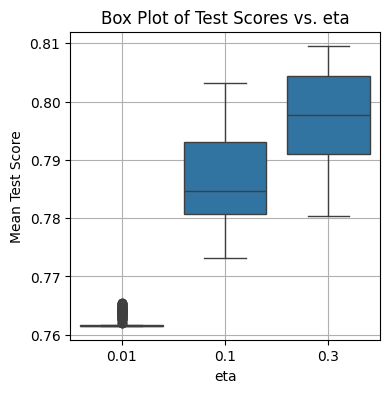

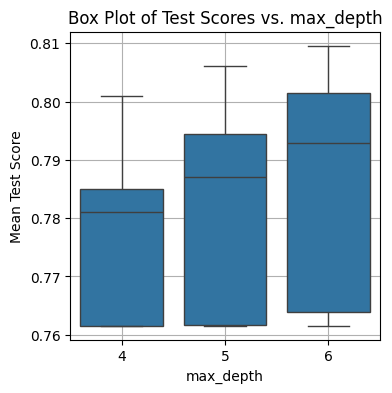

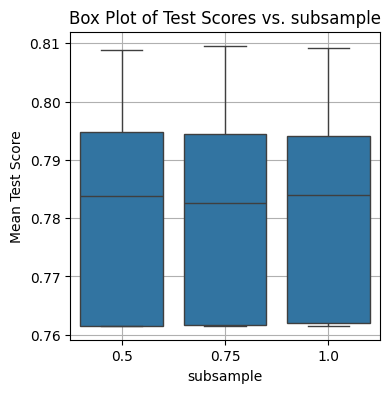

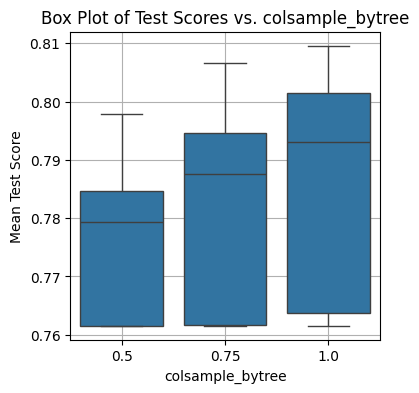

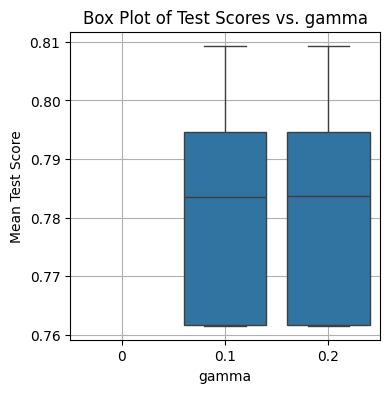

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the grid search results to a dataframe
results_df = pd.DataFrame(grid_search.cv_results_)

for param in param_grid.keys():
    plt.figure(figsize=(4,4))
    
    # Extract individual fold scores
    fold_scores = [results_df[f"split{i}_test_score"] for i in range(grid_search.cv)]
    fold_scores_df = pd.concat(fold_scores, axis=1)
    
    # Extract parameter values and add as a new column
    fold_scores_df[param] = results_df['param_' + param]
    
    # Melt the dataframe for seaborn
    melted_scores_df = fold_scores_df.melt(id_vars=param, 
                                           value_vars=[f"split{i}_test_score" for i in range(grid_search.cv)],
                                           var_name="cv_fold",
                                           value_name="score")

    # Boxplot
    sns.boxplot(data=melted_scores_df, x=param, y="score")
    plt.title(f'Box Plot of Test Scores vs. {param}')
    plt.ylabel('Mean Test Score')
    plt.grid(True)
    plt.show()


Accuracy: 0.8059793965997039

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88     72080
           1       0.76      0.29      0.42     23147

    accuracy                           0.81     95227
   macro avg       0.79      0.63      0.65     95227
weighted avg       0.80      0.81      0.77     95227



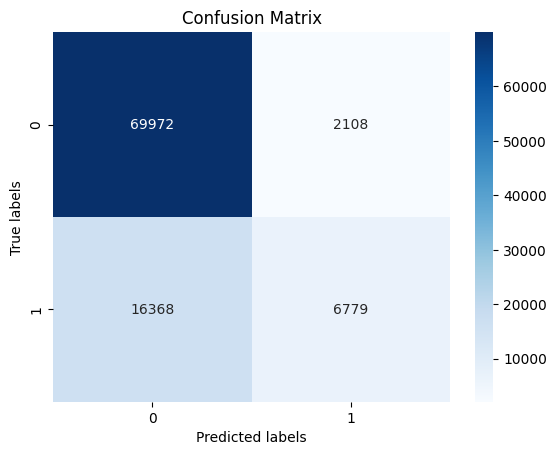

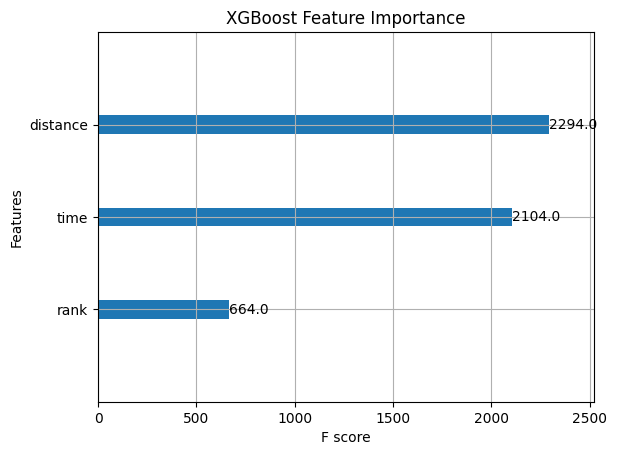

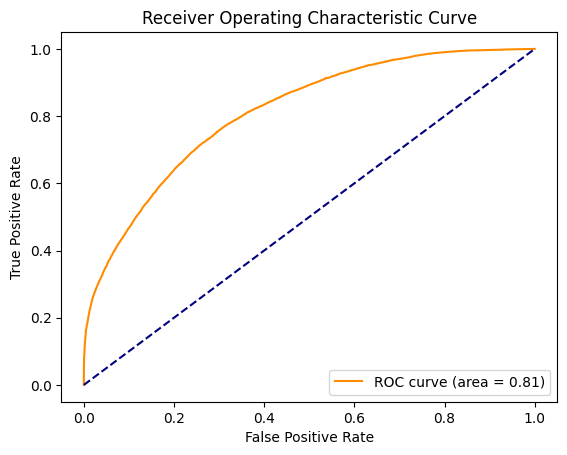

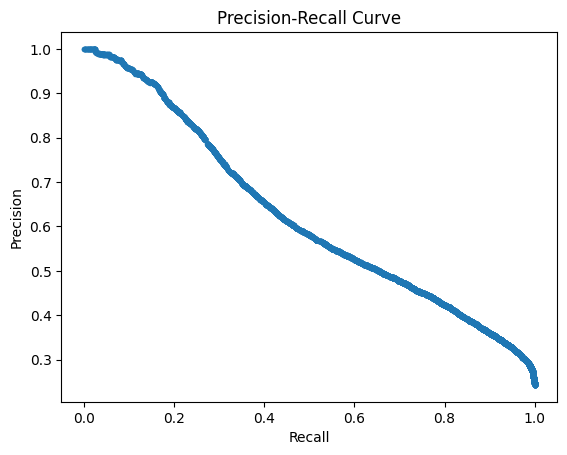

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import joblib

# 1. Testing on the Test Set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# 2. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# 3. Visualization

# Feature Importance
xgb.plot_importance(best_model)
plt.title('XGBoost Feature Importance')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


## Save Model

<Figure size 2000x1500 with 0 Axes>

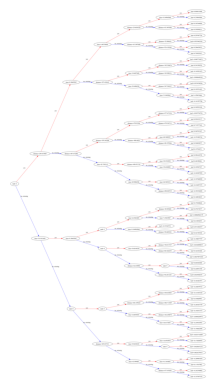

In [5]:
import matplotlib.pyplot as plt
# Plot first tree from the model
import os
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'
# Plot the first tree
plt.figure(figsize=(20, 15))
xgb.plot_tree(best_model, num_trees=0, rankdir='LR')
plt.show()


{'colsample_bytree': 1.0, 'eta': 0.3, 'gamma': 0.2, 'max_depth': 6, 'subsample': 1.0}


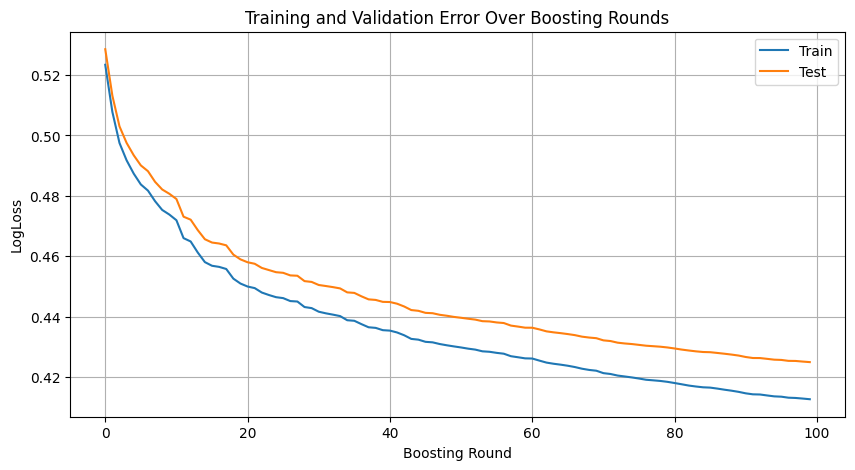

In [6]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Use the best parameters from the grid search
best_params = grid_search.best_params_
print(best_params)

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train,eval_set=eval_set, verbose=False)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results['validation_0']['logloss']
test_errors = results['validation_1']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('LogLoss')
plt.title('Training and Validation Error Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()


## N_estimator and early stopping

In [7]:
# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=1000, # Increasing n_estimators
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train, 
    y_train,
    eval_set=eval_set, 
    early_stopping_rounds=10, # Adding early stopping
    verbose=False
)

# Rest of your code remains unchanged


/Users/emiljino/anaconda3/envs/Diss/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

/Users/emiljino/anaconda3/envs/Diss/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


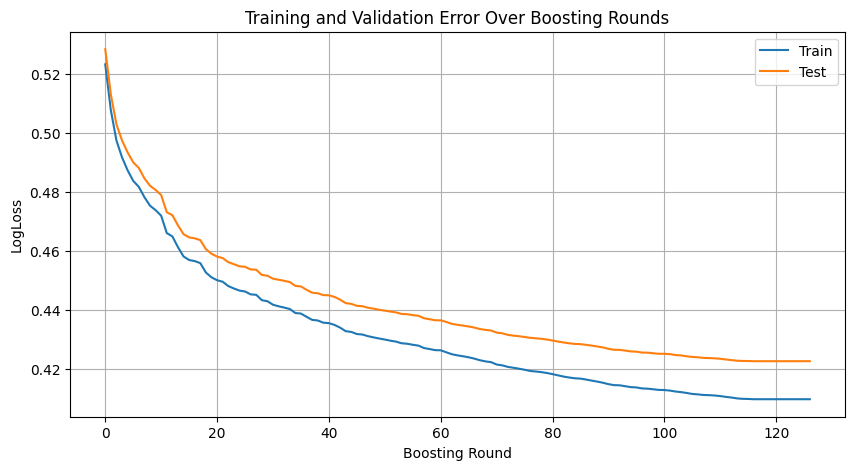

In [8]:
# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train,eval_set=eval_set,early_stopping_rounds=10,verbose=False)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results['validation_0']['logloss']
test_errors = results['validation_1']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('LogLoss')
plt.title('Training and Validation Error Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()


/Users/emiljino/anaconda3/envs/Diss/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best iteration: 116


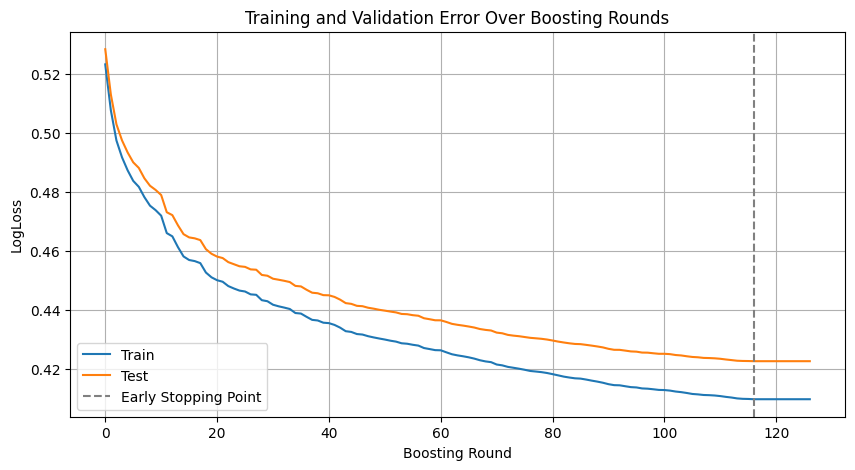

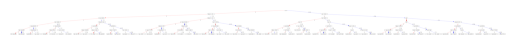

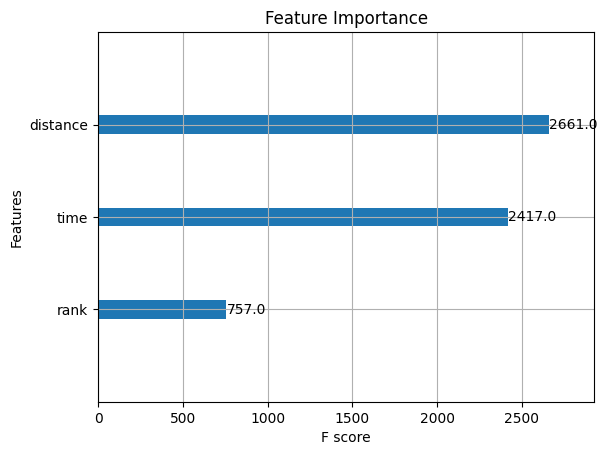

    Feature  Importance
3      rank    0.433892
2  distance    0.287783
0      time    0.278325
1     stake    0.000000


In [9]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=False)

# 1. Print the boosting round where early stopping occurred:
print(f"Best iteration: {best_xgb_estimator.get_booster().best_iteration}")
#print(f"Best ntree_limit: {best_xgb_estimator.get_booster().best_ntree_limit}")

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results['validation_0']['logloss']
test_errors = results['validation_1']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.axvline(x=best_xgb_estimator.get_booster().best_iteration, color='gray', linestyle='--', label='Early Stopping Point')
plt.xlabel('Boosting Round')
plt.ylabel('LogLoss')
plt.title('Training and Validation Error Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualize the model using XGBoost's plot functionalities:

# a. Plotting the first tree:
xgb.plot_tree(best_xgb_estimator, num_trees=0)
plt.show()

# b. Displaying the importance of each feature:
xgb.plot_importance(best_xgb_estimator)
plt.title('Feature Importance')
plt.show()

# If you'd like a table of feature importances:
importances = best_xgb_estimator.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)


              precision    recall  f1-score   support

           0       0.81      0.97      0.88     72080
           1       0.76      0.30      0.43     23147

    accuracy                           0.81     95227
   macro avg       0.79      0.63      0.65     95227
weighted avg       0.80      0.81      0.77     95227

[[69958  2122]
 [16316  6831]]


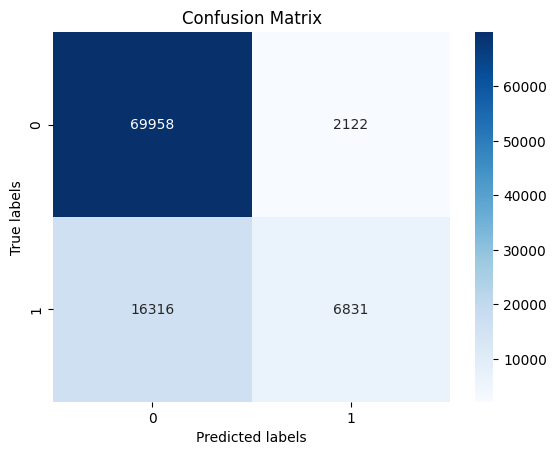

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predict the classes
y_pred = best_xgb_estimator.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [18]:
print(best_xgb_estimator.best_ntree_limit)


AttributeError: 'XGBClassifier' object has no attribute 'best_ntree_limit'

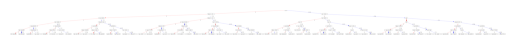

In [11]:
xgb.plot_tree(best_xgb_estimator, num_trees=0, max_depth=4)
plt.show()


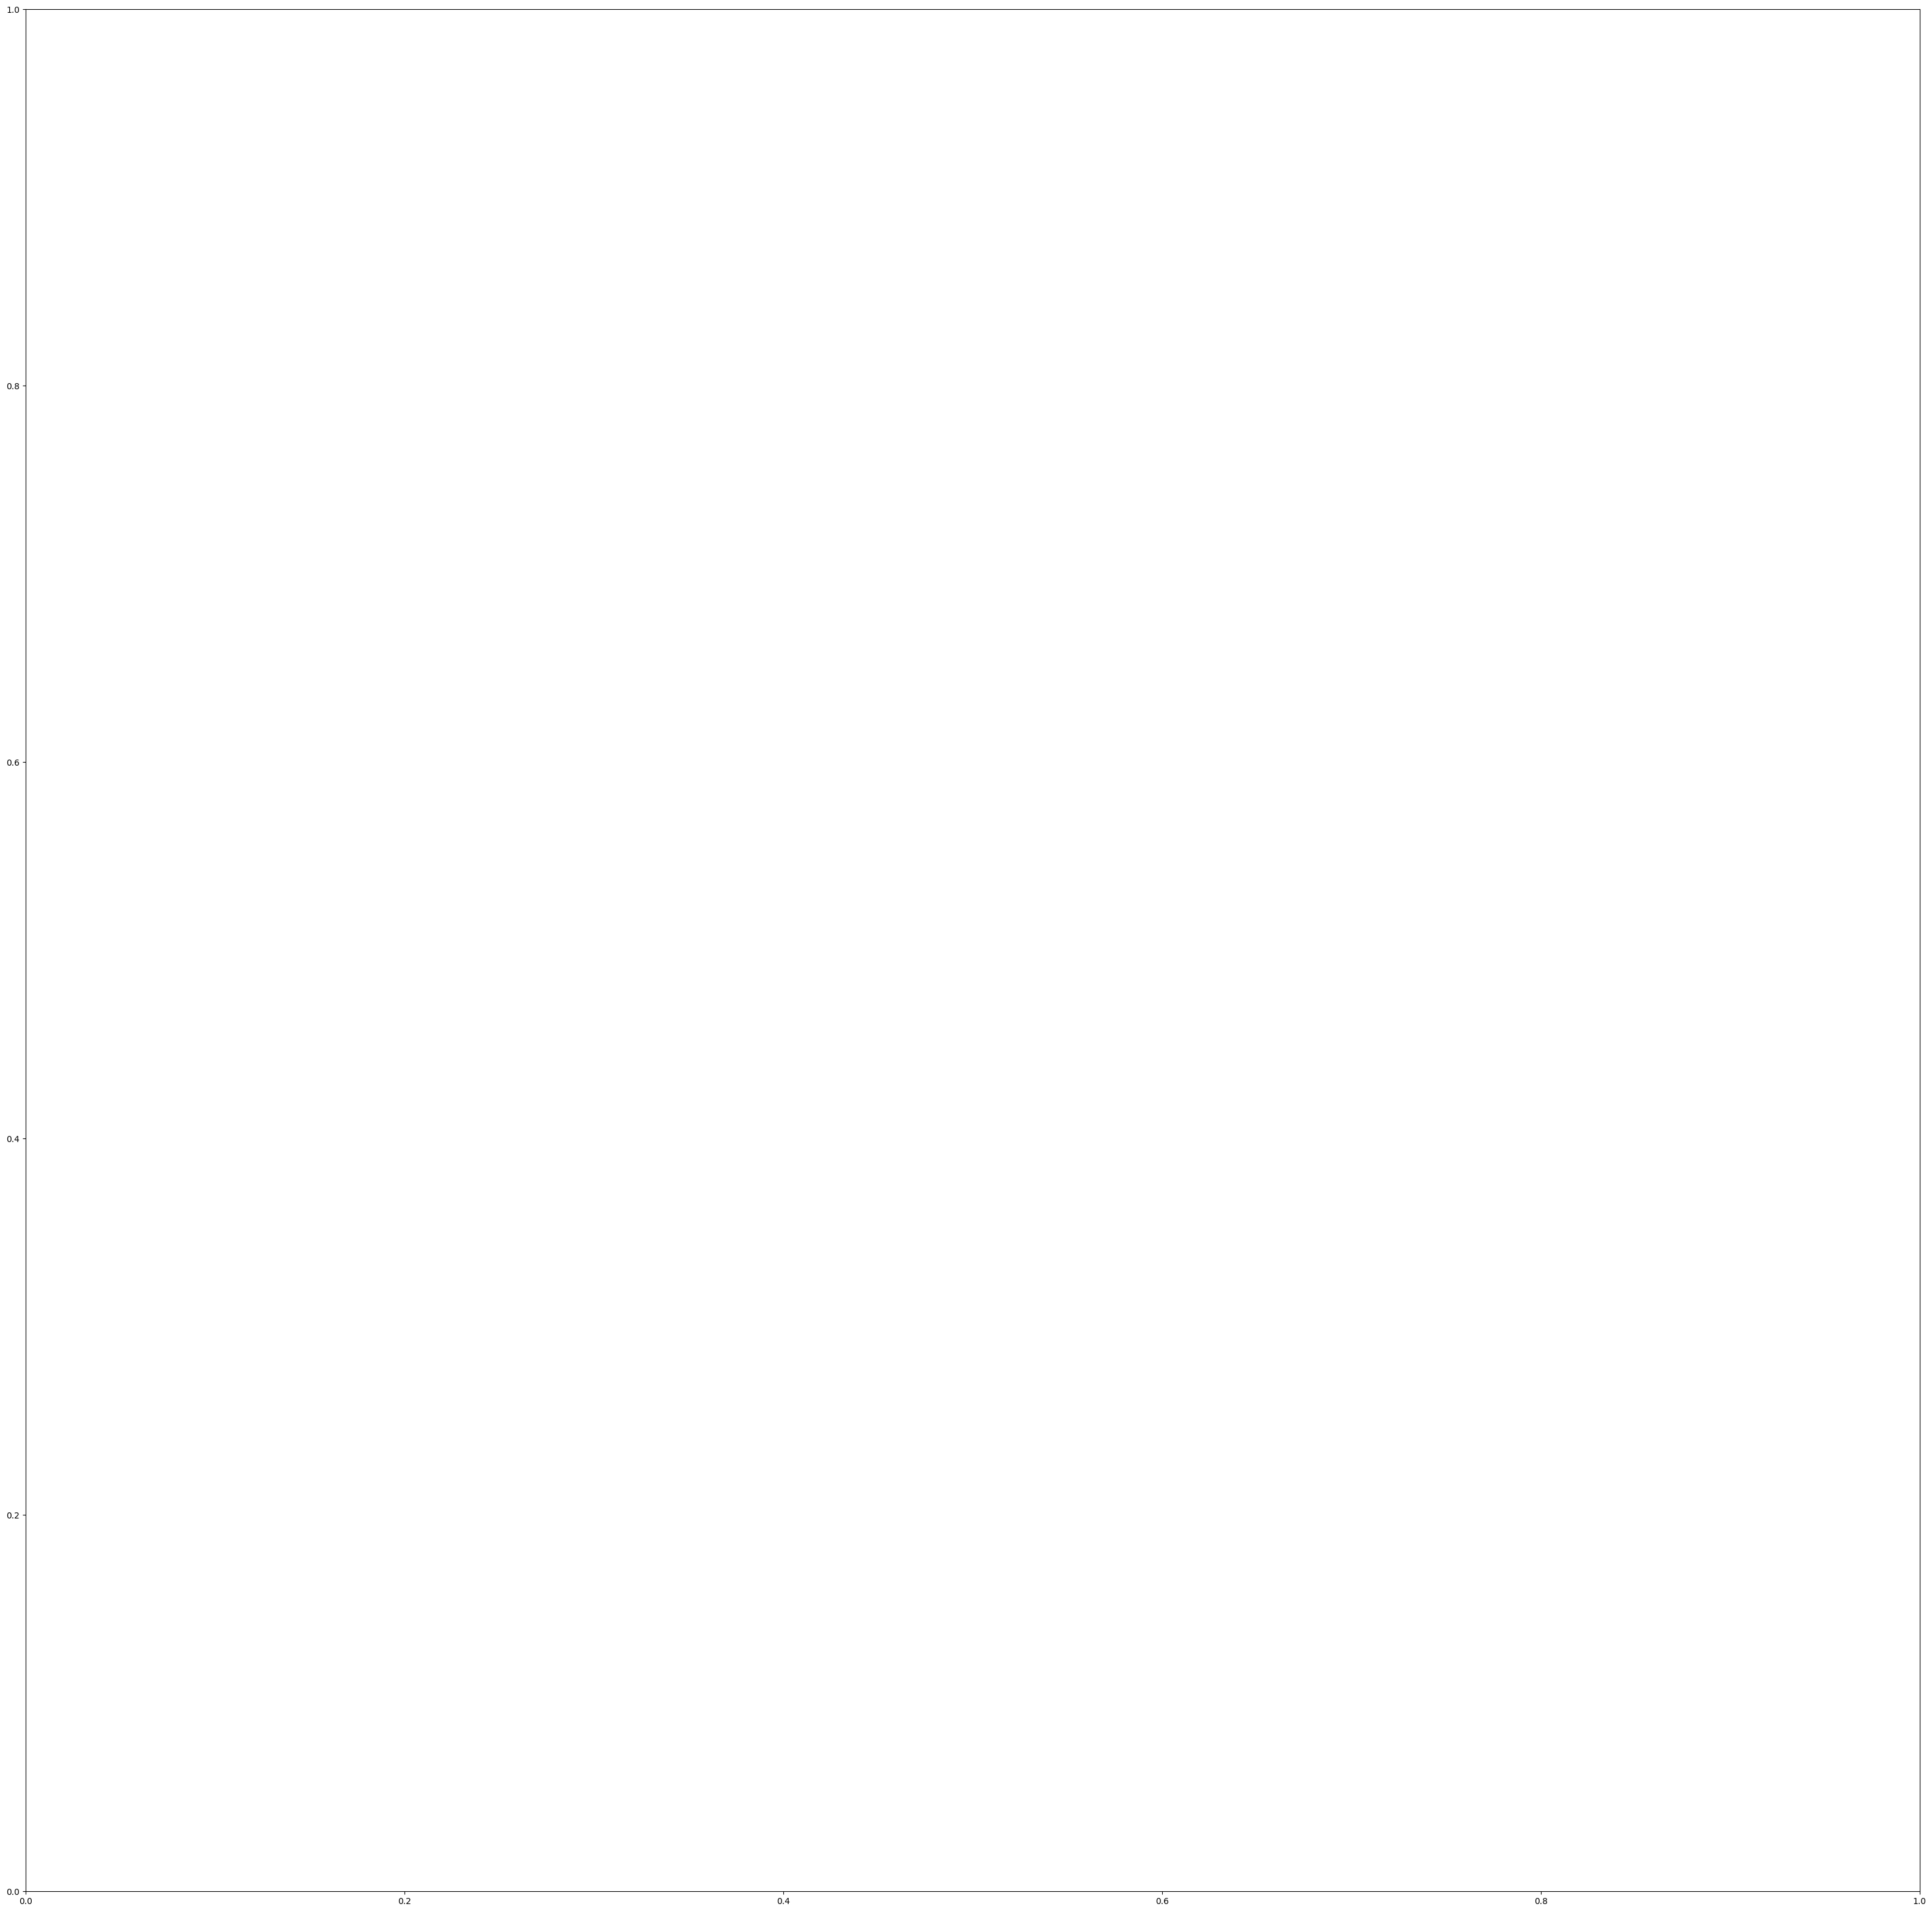

In [20]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Define figure size and resolution
fig, ax = plt.subplots(figsize=(40, 40))

# Plotting the tree with the max_depth option
xgb.plot_tree(best_xgb_estimator, num_trees=0, rankdir='LR')

# Saving the plot with increased resolution
plt.savefig("xgboost_tree.png", dpi=600)
plt.close()

# Save Model

In [23]:
# Save the best model to a .json file
best_model.get_booster().save_model('trained_xgboost_model.json')